# 5. CNN2

## 5-1. 이미지 분류
> 특정 대상이 영상(이미지) 내에 존재하는지 판단

### 5-1-1. LeNet-5
![LeNet5](https://i.imgur.com/tQGDtMp.jpg)
- MNIST
- 합성곱(Conv)과 다운 샘플링(sub-sampling)

| Layer Type | Ftr Map | Size | Kernel | Stride | Act. |
| :---: | :---: | :---: | :---: | :---: | :---: |
| 이미지 | 1 | 32*32 | - | - | - |
| 합성곱 | 6 | 28*28 | 5*5 | 1 | ReLU |
| 최대 풀링 | 6 | 14*14 | 2*2 | 2 | - |
| 합성곱 | 16 | 10*10 | 5*5 | 1 | ReLU |
| 최대 풀링 | 16 | 5*5 | 2*2 | 2 | - |
| FC | - | 120 | - | - | ReLU |
| FC | - | 84 | - | - | ReLU |
| FC | - | 2 | - | - | Softmax |

In [1]:
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.autograd import Variable
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
import os
import cv2
import time
from PIL import Image
from tqdm import tqdm
import random
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [2]:
class ImageTransform():
    def __init__(self, resize, mean, std):
        self.data_transform ={
            "train": transforms.Compose([
                transforms.RandomResizedCrop(resize, scale=(0.5, 1.0)),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ]),
            "val": transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(resize),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])
        }
    def __call__(self, img, phase):
        return self.data_transform[phase](img)

In [3]:
# Kaggle Train-Test 통합
cat_dir = r"../data/catanddog/Cat/"
dog_dir = r"../data/catanddog/Dog/"
#
cat_img_filepaths = sorted([os.path.join(cat_dir, f) for f in os.listdir(cat_dir)])
dog_img_filepaths = sorted([os.path.join(dog_dir, f) for f in os.listdir(dog_dir)])
image_filepaths = [*cat_img_filepaths, *dog_img_filepaths]
correct_images_filepaths = [i for i in image_filepaths if cv2.imread(i) is not None]
#
print(len(image_filepaths))
print(len(correct_images_filepaths))

483
483


In [4]:
random.seed(42)
random.shuffle(correct_images_filepaths)
train_images_filepaths = correct_images_filepaths[:400]
val_images_filepaths = correct_images_filepaths[400:-10]
test_images_filepaths = correct_images_filepaths[-10:]
print(len(train_images_filepaths), len(val_images_filepaths), len(test_images_filepaths))

400 73 10


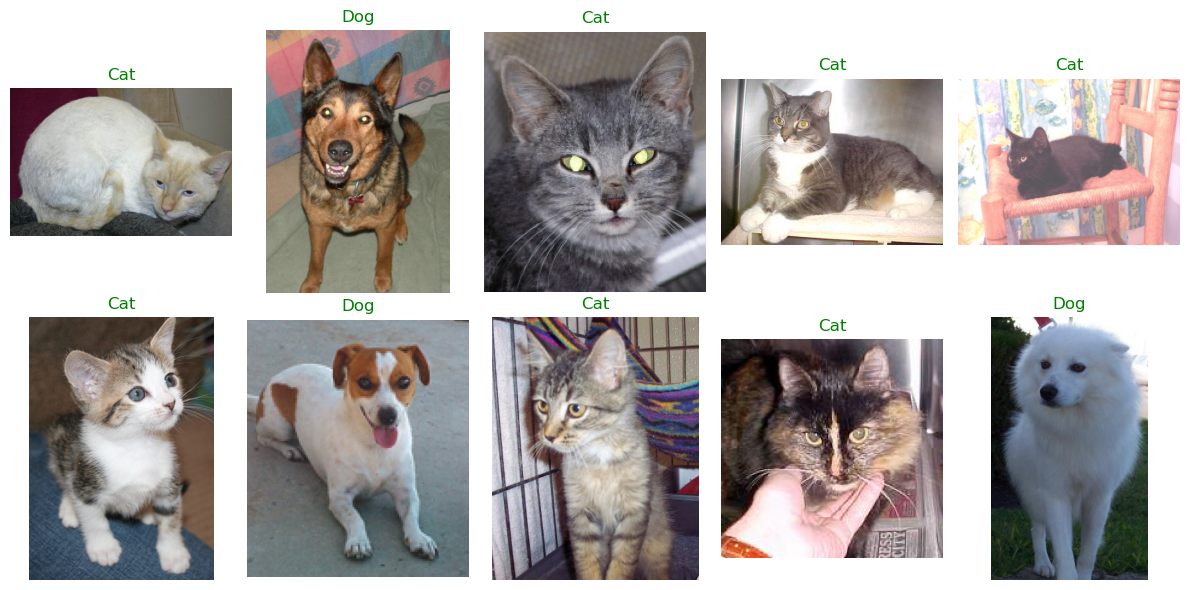

In [5]:
def display_image_grid(images_filepaths, predicted_labels=(), cols=5):
    rows = len(images_filepaths)//cols
    fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i, image_filepath in enumerate(images_filepaths):
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        true_label = os.path.normpath(image_filepath).split(os.sep)[-2]
        predicted_label = predicted_labels[i] if predicted_labels else true_label
        color = "green" if true_label==predicted_label else "red"
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_title(predicted_label, color=color)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()
#
display_image_grid(test_images_filepaths)

In [53]:
class DogvsCatDataset(Dataset):
    def __init__(self, file_list, transform=None, phase="train"):
        self.file_list = file_list
        self.transform = transform
        self.phase = phase
    def __len__(self):
        return len(self.file_list)
    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img, self.phase)
        label = train_images_filepaths[0].split("/")[-2].lower()
        if label=="dog": label=1
        else: label=0
        return img_transformed, label

In [54]:
CFG = {
    "SIZE":224,
    "MEAN":(0.485, 0.456, 0.406),
    "STD":(0.229, 0.224, 0.225),
    "BATCH_SIZE":32
}

In [55]:
train_dataset = DogvsCatDataset(train_images_filepaths, transform=ImageTransform(CFG["SIZE"], CFG["MEAN"], CFG["STD"]), phase="train")
val_dataset = DogvsCatDataset(val_images_filepaths, transform=ImageTransform(CFG["SIZE"], CFG["MEAN"], CFG["STD"]), phase="val")

idx=0
print(train_dataset.__getitem__(idx)[0].size())
print(train_dataset.__getitem__(idx)[1])

torch.Size([3, 224, 224])
1


In [56]:
train_dataloader = DataLoader(train_dataset, batch_size=CFG["BATCH_SIZE"], shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=CFG["BATCH_SIZE"], shuffle=False)
dataloader_dict = {"train":train_dataloader, "val":val_dataloader}
#
batch_iterator = iter(train_dataloader)
inputs, label = next(batch_iterator)
print(inputs.size())
print(label)

torch.Size([32, 3, 224, 224])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1])


In [57]:
# LeNet-5
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=0)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=0)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(32*53*53, 512)
        self.fc2 = nn.Linear(512, 2)
        self.output = nn.Softmax(dim=1)
    def forward(self, x):
        out = self.cnn1(x)
        out = self.relu1(out)
        out = self.maxpool1(out)
        out = self.cnn2(out)
        out = self.relu2(out)
        out = self.maxpool2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.output(out)
        return out
        
model = LeNet()
print(model)

LeNet(
  (cnn1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=89888, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
  (output): Softmax(dim=1)
)


In [58]:
# 학습 가능한 파라미터 수
def count_parameters(models):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"{count_parameters(model):,}")

46,038,242


In [59]:
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()
#
model = model.to(device)
criterion = criterion.to(device)
#
def train_moel(model, dataloader_dict, criterion, optimizer, num_epoch):
    since = time.time()
    best_acc = 0.0
    for epoch in range(num_epoch):
        print(f"Epoch {epoch+1}/{num_epoch}")
        print("-"*20)
        for phase in ["train", "val"]:
            if phase=="train": model.train()
            else: model.eval()
            epoch_loss, epoch_corrects = 0.0, 0.0
            for inputs, labels in tqdm(dataloader_dict[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase=="train"):
                    outputs = model(inputs)
                    _, preds = torch.max(torch.tensor(outputs), dim=1)
                    loss = criterion(outputs, labels)
                    if phase=="train":
                        loss.backward()
                        optimizer.step()
                    epoch_loss += loss.item()*inputs.size(0)
                    epoch_corrects += torch.sum(preds==labels.data)
            epoch_loss = epoch_loss / len(dataloader_dict[phase].dataset)
            epoch_acc = epoch_corrects.double() / len(dataloader_dict[phase].dataset)
            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")
            if phase=="val" and epoch_acc>best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()
    time_elapsed = time.time() - since
    print(f"Training Complete in {time_elapsed//60:.0f}m {time_elapsed%60:.0f}")
    print(f"Best val Acc: {best_acc:.4f}")
    return model

In [60]:
epochs = 10
model = train_moel(model, dataloader_dict, criterion, optimizer, epochs)

Epoch 1/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]C:\Users\nuyhc\AppData\Local\Temp\ipykernel_27964\1039798194.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  _, preds = torch.max(torch.tensor(outputs), dim=1)
100%|██████████| 13/13 [00:01<00:00, 10.79it/s]


train Loss: 0.3837 Acc: 0.9425


100%|██████████| 3/3 [00:00<00:00, 16.65it/s]


val Loss: 0.3134 Acc: 1.0000
Epoch 2/10
--------------------


100%|██████████| 13/13 [00:01<00:00, 10.79it/s]


train Loss: 0.3133 Acc: 1.0000


100%|██████████| 3/3 [00:00<00:00, 15.64it/s]


val Loss: 0.3133 Acc: 1.0000
Epoch 3/10
--------------------


100%|██████████| 13/13 [00:01<00:00, 10.46it/s]


train Loss: 0.3133 Acc: 1.0000


100%|██████████| 3/3 [00:00<00:00, 16.12it/s]


val Loss: 0.3133 Acc: 1.0000
Epoch 4/10
--------------------


100%|██████████| 13/13 [00:01<00:00, 10.16it/s]


train Loss: 0.3133 Acc: 1.0000


100%|██████████| 3/3 [00:00<00:00, 16.60it/s]


val Loss: 0.3133 Acc: 1.0000
Epoch 5/10
--------------------


100%|██████████| 13/13 [00:01<00:00, 10.47it/s]


train Loss: 0.3133 Acc: 1.0000


100%|██████████| 3/3 [00:00<00:00, 16.47it/s]


val Loss: 0.3133 Acc: 1.0000
Epoch 6/10
--------------------


100%|██████████| 13/13 [00:01<00:00, 10.17it/s]


train Loss: 0.3133 Acc: 1.0000


100%|██████████| 3/3 [00:00<00:00, 15.69it/s]


val Loss: 0.3133 Acc: 1.0000
Epoch 7/10
--------------------


100%|██████████| 13/13 [00:01<00:00, 10.46it/s]


train Loss: 0.3133 Acc: 1.0000


100%|██████████| 3/3 [00:00<00:00, 16.58it/s]


val Loss: 0.3133 Acc: 1.0000
Epoch 8/10
--------------------


100%|██████████| 13/13 [00:01<00:00, 10.17it/s]


train Loss: 0.3133 Acc: 1.0000


100%|██████████| 3/3 [00:00<00:00, 16.69it/s]


val Loss: 0.3133 Acc: 1.0000
Epoch 9/10
--------------------


100%|██████████| 13/13 [00:01<00:00, 10.47it/s]


train Loss: 0.3133 Acc: 1.0000


100%|██████████| 3/3 [00:00<00:00, 16.42it/s]


val Loss: 0.3133 Acc: 1.0000
Epoch 10/10
--------------------


100%|██████████| 13/13 [00:01<00:00, 10.53it/s]


train Loss: 0.3133 Acc: 1.0000


100%|██████████| 3/3 [00:00<00:00, 16.40it/s]

val Loss: 0.3133 Acc: 1.0000
Training Complete in 0m 14
Best val Acc: 1.0000


In [61]:
# Validate
import pandas as pd
id_list = []
pred_list = []
_id=0
with torch.no_grad():
    for test_path in tqdm(test_images_filepaths):
        img = Image.open(test_path)
        _id =test_path.split('/')[-1].split('.')[0]
        transform = ImageTransform(CFG["SIZE"], CFG["MEAN"], CFG["STD"])
        img = transform(img, phase='val')
        img = img.unsqueeze(0)
        img = img.to(device)

        model.eval()
        outputs = model(img)
        preds = F.softmax(outputs, dim=1)[:, 1].tolist()        
        id_list.append(_id)
        pred_list.append(preds[0])
       
res = pd.DataFrame({
    'id': id_list,
    'label': pred_list
})

res.sort_values(by='id', inplace=True)
res.reset_index(drop=True, inplace=True)

100%|██████████| 10/10 [00:00<00:00, 108.49it/s]


In [62]:
res

id     label
0     2  0.731058
1    31  0.730957
2    56  0.731059
3    60  0.731059
4  7549  0.731053
5  7592  0.731059
6  7603  0.731059
7  7618  0.731059
8  8113  0.731055
9  8115  0.731054

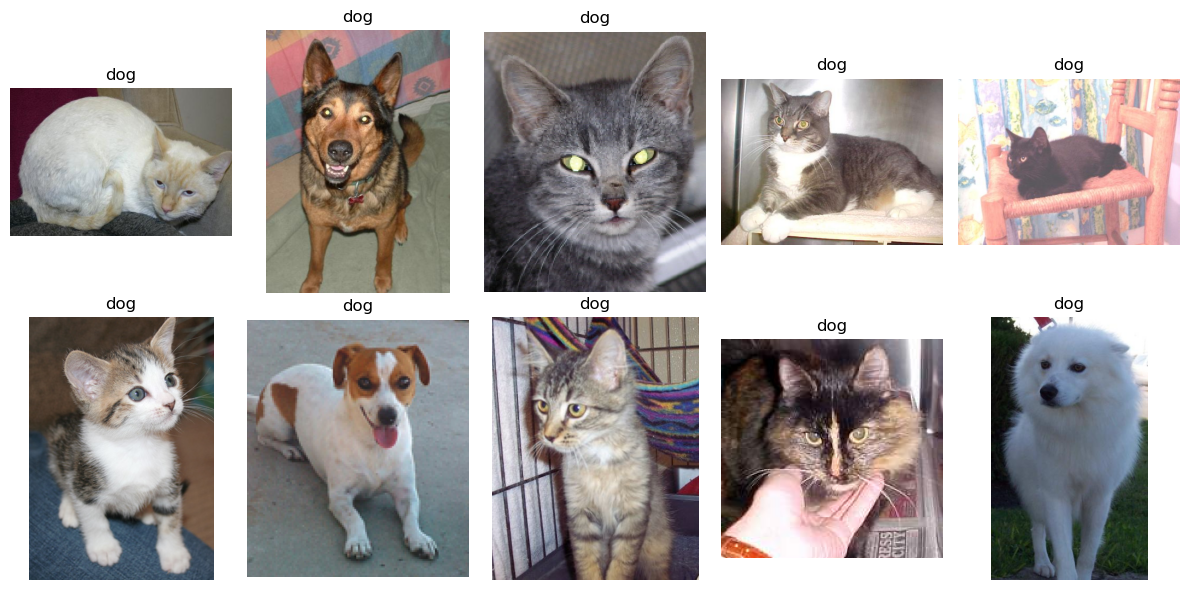

In [63]:
class_ = classes = {0:'cat', 1:'dog'}
def display_image_grid(images_filepaths, predicted_labels=(), cols=5):
    rows = len(images_filepaths) // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i, image_filepath in enumerate(images_filepaths):
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        a = random.choice(res['id'].values)    
        label = res.loc[res['id'] == a, 'label'].values[0]
        if label > 0.5:
            label = 1
        else:
            label = 0
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_title(class_[label])
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()

display_image_grid(test_images_filepaths) 

### 5-1-2. AlexNet
> ILSVRC 2012 
- GPU1 = Color X, GPU2 = Color O


![AlexNet](https://t1.daumcdn.net/cfile/tistory/99FEB93C5C80B5192E)

In [1]:
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
import os
import cv2
import random
from PIL import Image
from tqdm import tqdm

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [7]:
class ImageTransform():
    def __init__(self, resize, mean, std):
        self.data_transform = {
            "train": transforms.Compose([
                transforms.RandomResizedCrop(resize, scale=(0.5, 1.0)),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ]),
            "val": transforms.Compose([
               transforms.Resize(256),
               transforms.CenterCrop(resize),
               transforms.ToTensor(),
               transforms.Normalize(mean, std) 
            ])
        }
    def __call__(self, img, phase):
        return self.data_transform[phase](img)

In [8]:
cat_dir = "../data/dogs-vs-cats/Cat/"
dog_dir = "../data/dogs-vs-cats/Dog/"
#
cat_images_filepaths = sorted([os.path.join(cat_dir, f) for f in os.listdir(cat_dir)])
dog_images_filepaths = sorted([os.path.join(dog_dir, f) for f in os.listdir(dog_dir)])
images_filepaths = [*cat_images_filepaths, *dog_images_filepaths]
correct_images_filepaths = [i for i in images_filepaths if cv2.imread(i) is not None]

random.seed(42)
random.shuffle(correct_images_filepaths)
train_images_filepaths = correct_images_filepaths[:400]
val_images_filepaths = correct_images_filepaths[400:-10]
test_images_filepaths = correct_images_filepaths[-10:]
#
print(len(train_images_filepaths), len(val_images_filepaths), len(test_images_filepaths))

400 92 10


In [9]:
class DogvsCatDataset(Dataset):
    def __init__(self, file_list, transform=None, phase="train"):
        self.file_list = file_list
        self.transform = transform
        self.phase = phase
    def __len__(self):
        return len(self.file_list)
    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img, self.phase)
        #
        label = img_path.split("/")[-1].split(".")[0]
        if label=="dog": label=1
        else: label=0
        #
        return img_transformed, label

In [10]:
size = 256
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
batch_size = 32

In [11]:
train_dataset = DogvsCatDataset(train_images_filepaths, transform=ImageTransform(size, mean, std), phase="train")
val_dataset = DogvsCatDataset(val_images_filepaths, transform=ImageTransform(size, mean, std), phase="val")
test_dataset = DogvsCatDataset(test_images_filepaths, transform=ImageTransform(size, mean, std), phase="val")
#
idx = 0
print(train_dataset.__getitem__(idx)[0].size())
print(train_dataset.__getitem__(idx)[1])

torch.Size([3, 256, 256])
0


In [15]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
dataloader_dict = {"train": train_dataloader, "val": val_dataloader}
#
batch_iterator = iter(train_dataloader)
inputs, outputs = next(batch_iterator)
print(inputs.size())
print(outputs)

torch.Size([32, 3, 256, 256])
tensor([0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0,
        1, 0, 0, 0, 0, 1, 1, 0])


In [16]:
class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, padding=1),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256*6*6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 2)
        )
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [17]:
model = AlexNet()
model = model.to(device)

In [18]:
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

In [19]:
from torchsummary import summary

summary(model, input_size=(3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 63, 63]          23,296
              ReLU-2           [-1, 64, 63, 63]               0
         MaxPool2d-3           [-1, 64, 31, 31]               0
            Conv2d-4          [-1, 192, 31, 31]         307,392
              ReLU-5          [-1, 192, 31, 31]               0
         MaxPool2d-6          [-1, 192, 11, 11]               0
            Conv2d-7          [-1, 384, 11, 11]         663,936
              ReLU-8          [-1, 384, 11, 11]               0
            Conv2d-9          [-1, 256, 11, 11]         884,992
             ReLU-10          [-1, 256, 11, 11]               0
           Conv2d-11          [-1, 256, 11, 11]         590,080
             ReLU-12          [-1, 256, 11, 11]               0
        MaxPool2d-13            [-1, 256, 5, 5]               0
AdaptiveAvgPool2d-14            [-1, 25

In [22]:
import time
def train_model(model, dataloader_dict, criterion, optimizer, epochs):
    since = time.time()
    best_acc = 0.0
    
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        print("-"*20)
        #
        for phase in ["train", "val"]:
            if phase=="train": model.train()
            else: model.eval()
            #
            epoch_loss = 0.0
            epoch_corrects = 0
            #
            for inputs, labels in tqdm(dataloader_dict[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                #
                with torch.set_grad_enabled(phase=="train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    #
                    if phase=="train":
                        loss.backward()
                        optimizer.step()
                    epoch_loss += loss.item() * inputs.size(0)
                    epoch_corrects += torch.sum(preds==labels.data)
            #
            epoch_loss = epoch_loss/len(dataloader_dict[phase].dataset)
            epoch_acc = epoch_corrects.double() / len(dataloader_dict[phase].dataset)
            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")
    time_elapsed = time.time() - since
    print(f"Training complete in {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s")
    return model

In [23]:
epochs = 10
model = train_model(model, dataloader_dict, criterion, optimizer, epochs)

Epoch 1/10
--------------------


100%|██████████| 13/13 [00:01<00:00,  7.47it/s]


train Loss: 0.6936 Acc: 0.4975


100%|██████████| 3/3 [00:00<00:00, 11.86it/s]


val Loss: 0.6939 Acc: 0.4891
Epoch 2/10
--------------------


100%|██████████| 13/13 [00:01<00:00, 10.94it/s]


train Loss: 0.6935 Acc: 0.4975


100%|██████████| 3/3 [00:00<00:00, 12.77it/s]


val Loss: 0.6938 Acc: 0.4891
Epoch 3/10
--------------------


100%|██████████| 13/13 [00:01<00:00, 10.73it/s]


train Loss: 0.6929 Acc: 0.4975


100%|██████████| 3/3 [00:00<00:00, 12.50it/s]


val Loss: 0.6937 Acc: 0.4891
Epoch 4/10
--------------------


100%|██████████| 13/13 [00:01<00:00, 10.81it/s]


train Loss: 0.6933 Acc: 0.4975


100%|██████████| 3/3 [00:00<00:00, 12.75it/s]


val Loss: 0.6935 Acc: 0.4891
Epoch 5/10
--------------------


100%|██████████| 13/13 [00:01<00:00, 11.30it/s]


train Loss: 0.6933 Acc: 0.4975


100%|██████████| 3/3 [00:00<00:00, 12.70it/s]


val Loss: 0.6934 Acc: 0.4891
Epoch 6/10
--------------------


100%|██████████| 13/13 [00:01<00:00, 11.33it/s]


train Loss: 0.6932 Acc: 0.4975


100%|██████████| 3/3 [00:00<00:00, 12.78it/s]


val Loss: 0.6933 Acc: 0.4891
Epoch 7/10
--------------------


100%|██████████| 13/13 [00:01<00:00, 10.99it/s]


train Loss: 0.6932 Acc: 0.5025


100%|██████████| 3/3 [00:00<00:00, 12.68it/s]


val Loss: 0.6933 Acc: 0.4891
Epoch 8/10
--------------------


100%|██████████| 13/13 [00:01<00:00, 10.45it/s]


train Loss: 0.6931 Acc: 0.5025


100%|██████████| 3/3 [00:00<00:00, 12.53it/s]


val Loss: 0.6932 Acc: 0.4891
Epoch 9/10
--------------------


100%|██████████| 13/13 [00:01<00:00, 10.66it/s]


train Loss: 0.6930 Acc: 0.5000


100%|██████████| 3/3 [00:00<00:00, 12.72it/s]


val Loss: 0.6931 Acc: 0.4891
Epoch 10/10
--------------------


100%|██████████| 13/13 [00:01<00:00, 10.77it/s]


train Loss: 0.6930 Acc: 0.5300


100%|██████████| 3/3 [00:00<00:00, 12.65it/s]

val Loss: 0.6929 Acc: 0.5109
Training complete in 0m 15s


In [25]:
import pandas as pd
id_list = []
pred_list = []
_id = 0
with torch.no_grad():
    for test_path in tqdm(test_images_filepaths):
        img = Image.open(test_path)
        _id = test_path.split("/")[-1].split(".")[1]
        transform = ImageTransform(size, mean, std)
        img = transform(img, phase="val")
        img = img.unsqueeze(0)
        img = img.to(device)
        #
        model.eval()
        outputs = model(img)
        preds = F.softmax(outputs, dim=1)[:, 1].tolist()
        #
        id_list.append(_id)
        pred_list.append(preds[0])

res = pd.DataFrame({
    "id":id_list,
    "label":pred_list
})

res.head(10)

100%|██████████| 10/10 [00:00<00:00, 44.67it/s]


id     label
0  145  0.498823
1  211  0.499402
2  162  0.499027
3  200  0.500486
4  210  0.499889
5  224  0.498975
6  213  0.498723
7  109  0.500269
8   15  0.499252
9  167  0.498490

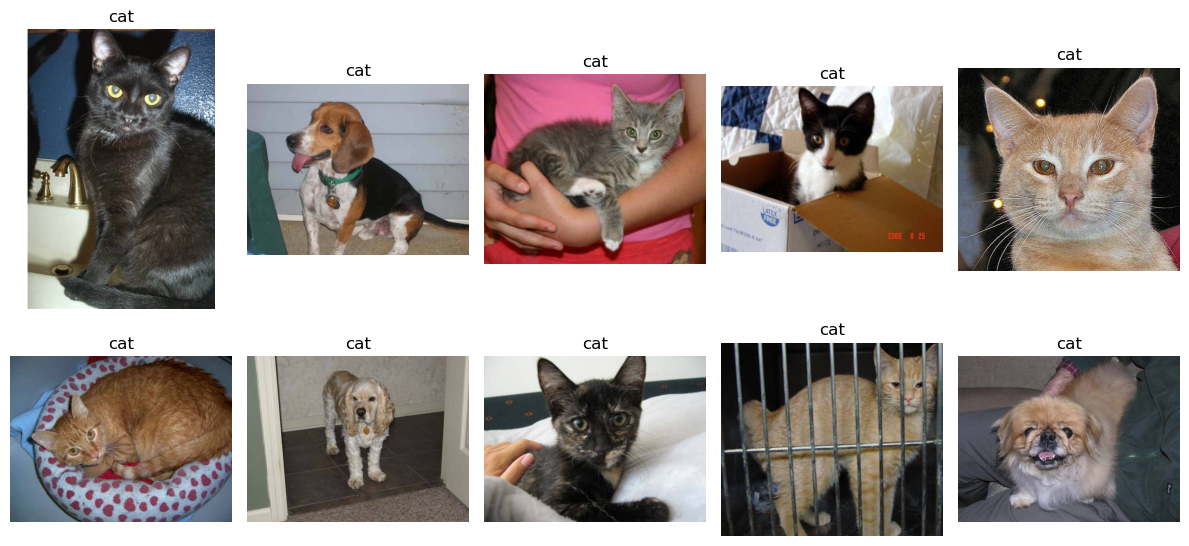

In [27]:
import matplotlib.pyplot as plt

class_ = classes = {0:'cat', 1:'dog'}
def display_image_grid(images_filepaths, predicted_labels=(), cols=5):
    rows = len(images_filepaths) // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i, image_filepath in enumerate(images_filepaths):
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        a = random.choice(res['id'].values)    
        label = res.loc[res['id'] == a, 'label'].values[0]
        if label > 0.5:
            label = 1
        else:
            label = 0
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_title(class_[label])
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()
    
display_image_grid(test_images_filepaths)

### 5-1-3. VGGNet
> Conv의 필터/커널 크기를 3X3으로 고정

![VGG16](https://miro.medium.com/v2/resize:fit:857/1*AqqArOvacibWqeulyP_-8Q.png)

### 5-1-4. ResNet ★
- 신경망의 깊이가 깊어지면 깊어질수록, 성능이 좋아지다가 일정한 단계에 이르면 성능이 나빠짐
- 레지듀얼 블록(residual block) 도입 -> 기울기 전파를 위한 숏컷(shortcut)
  - 아이덴티티 맵핑(identity mapping) / 스킵 연결(skip connection)
  - 어떤 함수를 통과해도 입력 x가 출력 x로 나옴
- 블록(block) = 계층의 묶음

![ResNet](https://velog.velcdn.com/images/choonsik_mom/post/e6285ac6-6334-411c-a087-64e4aae1b5e1/image.png)

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

import matplotlib.pyplot as plt
import numpy as np

import copy
from collections import namedtuple
import os
import random
import time

import cv2
from torch.utils.data import Dataset, DataLoader
from PIL import Image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [2]:
class ImageTransform():
    def __init__(self, resize, mean, std):
        self.data_transform ={
            "train": transforms.Compose([
                transforms.RandomResizedCrop(resize, scale=(0.5, 1.0)),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ]),
            "val": transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(resize),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])
        }
    def __call__(self, img, phase):
        return self.data_transform[phase](img)
    
size = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
batch_size = 32

In [3]:
cat_dir = "../data/dogs-vs-cats/Cat/"
dog_dir = "../data/dogs-vs-cats/Dog/"
#
cat_images_filepaths = sorted([os.path.join(cat_dir, f) for f in os.listdir(cat_dir)])
dog_images_filepaths = sorted([os.path.join(dog_dir, f) for f in os.listdir(dog_dir)])
images_filepaths = [*cat_images_filepaths, *dog_images_filepaths]
correct_images_filepaths = [i for i in images_filepaths if cv2.imread(i) is not None]

random.seed(42)
random.shuffle(correct_images_filepaths)
train_images_filepaths = correct_images_filepaths[:400]
val_images_filepaths = correct_images_filepaths[400:-10]
test_images_filepaths = correct_images_filepaths[-10:]
#
print(len(train_images_filepaths), len(val_images_filepaths), len(test_images_filepaths))

#
class DogvsCatDataset(Dataset):
    def __init__(self, file_list, transform=None, phase="train"):
        self.file_list = file_list
        self.transform = transform
        self.phase = phase
    def __len__(self):
        return len(self.file_list)
    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img, self.phase)
        #
        label = img_path.split("/")[-1].split(".")[0]
        if label=="dog": label=1
        else: label=0
        #
        return img_transformed, label
    
#
train_dataset = DogvsCatDataset(train_images_filepaths, transform=ImageTransform(size, mean, std), phase="train")
val_dataset = DogvsCatDataset(val_images_filepaths, transform=ImageTransform(size, mean, std), phase="val")
test_dataset = DogvsCatDataset(test_images_filepaths, transform=ImageTransform(size, mean, std), phase="val")
#
idx = 0
print(train_dataset.__getitem__(idx)[0].size())
print(train_dataset.__getitem__(idx)[1])

#
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
dataloader_dict = {"train": train_dataloader, "val": val_dataloader}
#
batch_iterator = iter(train_dataloader)
inputs, outputs = next(batch_iterator)
print(inputs.size())
print(outputs)

400 92 10
torch.Size([3, 224, 224])
0
torch.Size([32, 3, 224, 224])
tensor([1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0,
        0, 0, 0, 1, 1, 1, 1, 0])


In [4]:
class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_channels, out_channels, stride=1, downsample=False):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False) # 3x3 Conv
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False) # 3x3 Conv
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        if downsample:
            conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False)
            bn = nn.BatchNorm2d(out_channels)
            downsample = nn.Sequential(conv, bn)
        else:
            downsample = None
        self.downsample = downsample
    def forward(self, x):
        i = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        if self.downsample is not None:
            i = self.downsample(i)
        x += i
        x = self.relu(x)
        return x
    
class Bottleneck(nn.Module):
    expansion = 4
    def __init__(self, in_channels, out_channels, stride=1, downsample=False):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, self.expansion*out_channels, kernel_size=1, stride=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*out_channels)
        self.relu = nn.ReLU(inplace=True)
        if downsample:
            conv = nn.Conv2d(in_channels, self.expansion*out_channels, kernel_size=1, stride=stride, bias=False)
            bn = nn.BatchNorm2d(self.expansion*out_channels)
            downsample = nn.Sequential(conv, bn)
        else:
            downsample = None
        self.downsample = downsample
    def forward(self, x):
        i = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)
        if self.downsample is not None:
            i = self.downsample(i)
        x += i
        x = self.relu(x)
        return x

In [5]:
class ResNet(nn.Module):
    def __init__(self, config, output_dim, zero_init_residual=False):
        super().__init__()
        block, n_blocks, channels = config
        self.in_channels = channels[0]
        assert len(n_blocks)==len(channels)==4
        #
        self.conv1 = nn.Conv2d(3, self.in_channels, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        #
        self.layer1 = self.get_resnet_layer(block, n_blocks[0], channels[0])
        self.layer2 = self.get_resnet_layer(block, n_blocks[1], channels[1], stride=2)
        self.layer3 = self.get_resnet_layer(block, n_blocks[2], channels[2], stride=2)
        self.layer4 = self.get_resnet_layer(block, n_blocks[3], channels[3], stride=2)
        #
        self.avgpool = nn.AdaptiveMaxPool2d((1, 1))
        self.fc = nn.Linear(self.in_channels, output_dim)
        #
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant(m.bn2.weight, 0)
    def get_resnet_layer(self, block, n_blocks, channels, stride=1):
        layers = []
        if self.in_channels!=block.expansion*channels:
            downsample=True
        else:
            downsample=False
        layers.append(block(self.in_channels, channels, stride, downsample))
        for i in range(1, n_blocks):
            layers.append(block(block.expansion*channels, channels))
        self.in_channels = block.expansion*channels
        return nn.Sequential(*layers)
    def forward(self, x):
        x = self.conv1(x) # 224x224
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x) # 112x112
        x = self.layer1(x) # 56x56
        x = self.layer2(x) # 28x28
        x = self.layer3(x) # 14x14
        x = self.layer4(x) # 7x7
        x = self.avgpool(x) # 1x1
        h = x.view(x.shape[0], -1)
        x =self.fc(h)
        return x, h

In [6]:
ResNetConfig = namedtuple("ResNetConfig", ["block", "n_blocks", "channels"])
#
resnet18_config = ResNetConfig(block=BasicBlock,
                               n_blocks=[2, 2, 2, 2],
                               channels=[64, 128, 256, 512])
resnet34_config = ResNetConfig(block=BasicBlock,
                               n_blocks=[3, 4, 6, 3],
                               channels=[64, 128, 256, 512])
#
resnet50_config = ResNetConfig(block=Bottleneck,
                               n_blocks=[3, 4, 6, 3],
                               channels=[64, 128, 256, 512])
resnet101_config = ResNetConfig(block=Bottleneck,
                                n_blocks=[3, 4, 23, 3],
                                channels=[64, 128, 256, 512])
resnet152_config = ResNetConfig(block=Bottleneck,
                                n_blocks=[3, 8, 36, 3],
                                channels=[64, 128, 256, 512])

In [8]:
# 사전 훈련된 ResNet
pretrained_model = models.resnet50()

print(pretrained_model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [9]:
model = ResNet(resnet50_config, 2) # output_dim = 클래스 수
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [10]:
optimizer = optim.Adam(model.parameters(), lr=1e-7)
criterion = nn.CrossEntropyLoss()
#
model = model.to(device)
criterion = criterion.to(device)

In [11]:
# 모델 정확도 측정 함수
def calculate_topk_accuracy(y_pred, y, k=2):
    with torch.no_grad():
        batch_size = y.shape[0]
        _, top_pred = y_pred.topk(k, 1)
        top_pred = top_pred.t()
        correct = top_pred.eq(y.view(1, -1).expand_as(top_pred))
        correct_1 = correct[:1].reshape(-1).float().sum(0, keepdim=True)
        correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
        acc_1 = correct_1/batch_size
        acc_k = correct_k/batch_size
    return acc_1, acc_k

In [15]:
def train(model, iterator, optimizer, criterion, device):
    epoch_loss, epoch_acc_1, epoch_acc_5 = 0, 0, 0
    model.train()
    for (x, y) in iterator:
        x = x.to(device)
        y = y.to(device)
        #
        optimizer.zero_grad()
        y_pred = model(x)
        loss = criterion(y_pred[0], y)
        #
        acc_1, acc_5 = calculate_topk_accuracy(y_pred[0], y)
        loss.backward()
        optimizer.step()
        #
        epoch_loss += loss.item()
        epoch_acc_1 += acc_1.item()
        epoch_acc_5 += acc_5.item()
    epoch_loss /= len(iterator)
    epoch_acc_1 /= len(iterator)
    epoch_acc_5 /= len(iterator)
    return epoch_loss, epoch_acc_1, epoch_acc_5

def eval(model, iterator, criterion, device):
    epoch_loss, epoch_acc_1, epoch_acc_5 = 0, 0, 0
    model.eval()
    with torch.no_grad():
        for (x, y) in iterator:
            x = x.to(device)
            y = y.to(device)
            y_pred = model(x)
            loss = criterion(y_pred[0], y)
            #
            acc_1, acc_5 = calculate_topk_accuracy(y_pred[0], y)
            epoch_loss += loss.item()
            epoch_acc_1 += acc_1.item()
            epoch_acc_5 += acc_5.item()
    epoch_loss /= len(iterator)
    epoch_acc_1 /= len(iterator)
    epoch_acc_5 /= len(iterator)
    return epoch_loss, epoch_acc_1, epoch_acc_5

In [13]:
# 모델 학습 시간 측정 함수
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time/60)
    elapsed_secs = int(elapsed_time-(elapsed_mins*60))
    return elapsed_secs, elapsed_secs

In [17]:
# 모델 학습
best_valid_loss = float("inf")
for epoch in range(10):
    start_time = time.monotonic()
    train_loss, train_acc_1, train_acc_5 = train(model, train_dataloader, optimizer, criterion, device)
    valid_loss, valid_acc_1, valid_acc_5 = eval(model, val_dataloader, criterion, device)
    #
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), "./ResNet-model.pt")
    #
    end_time = time.monotonic()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    #
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc @1: {train_acc_1*100:6.2f}% | ' \
          f'Train Acc @5: {train_acc_5*100:6.2f}%')
    print(f'\tValid Loss: {valid_loss:.3f} | Valid Acc @1: {valid_acc_1*100:6.2f}% | ' \
          f'Valid Acc @5: {valid_acc_5*100:6.2f}%')

Epoch: 01 | Epoch Time: 2m 2s
	Train Loss: 2.563 | Train Acc @1:  49.76% | Train Acc @5: 100.00%
	Valid Loss: 0.720 | Valid Acc @1:  51.19% | Valid Acc @5: 100.00%
Epoch: 02 | Epoch Time: 2m 2s
	Train Loss: 2.393 | Train Acc @1:  50.24% | Train Acc @5: 100.00%
	Valid Loss: 0.990 | Valid Acc @1:  51.19% | Valid Acc @5: 100.00%
Epoch: 03 | Epoch Time: 2m 2s
	Train Loss: 2.584 | Train Acc @1:  49.28% | Train Acc @5: 100.00%
	Valid Loss: 1.586 | Valid Acc @1:  51.19% | Valid Acc @5: 100.00%
Epoch: 04 | Epoch Time: 2m 2s
	Train Loss: 2.409 | Train Acc @1:  50.00% | Train Acc @5: 100.00%
	Valid Loss: 1.909 | Valid Acc @1:  51.19% | Valid Acc @5: 100.00%
Epoch: 05 | Epoch Time: 2m 2s
	Train Loss: 2.359 | Train Acc @1:  50.00% | Train Acc @5: 100.00%
	Valid Loss: 1.975 | Valid Acc @1:  51.19% | Valid Acc @5: 100.00%
Epoch: 06 | Epoch Time: 2m 2s
	Train Loss: 2.419 | Train Acc @1:  50.24% | Train Acc @5: 100.00%
	Valid Loss: 1.991 | Valid Acc @1:  51.19% | Valid Acc @5: 100.00%
Epoch: 07 | Epoc

In [18]:
import pandas as pd
id_list = []
pred_list = []
_id = 0
with torch.no_grad():
    for test_path in test_images_filepaths:
        img = Image.open(test_path)
        _id = test_path.split("/")[-1].split(".")[1]
        transform = ImageTransform(size, mean, std)
        img = transform(img, phase="val")
        img = img.unsqueeze(0)
        img = img.to(device)
        #
        model.eval()
        outputs = model(img)
        preds = F.softmax(outputs[0], dim=1)[:, 1].tolist()
        id_list.append(_id)
        pred_list.append(preds[0])
        
res = pd.DataFrame({
    "id":id_list,
    "label":pred_list
})

res

id     label
0  145  0.972281
1  211  0.938826
2  162  0.974840
3  200  0.995265
4  210  0.975750
5  224  0.903048
6  213  0.957897
7  109  0.997827
8   15  0.948567
9  167  0.931099

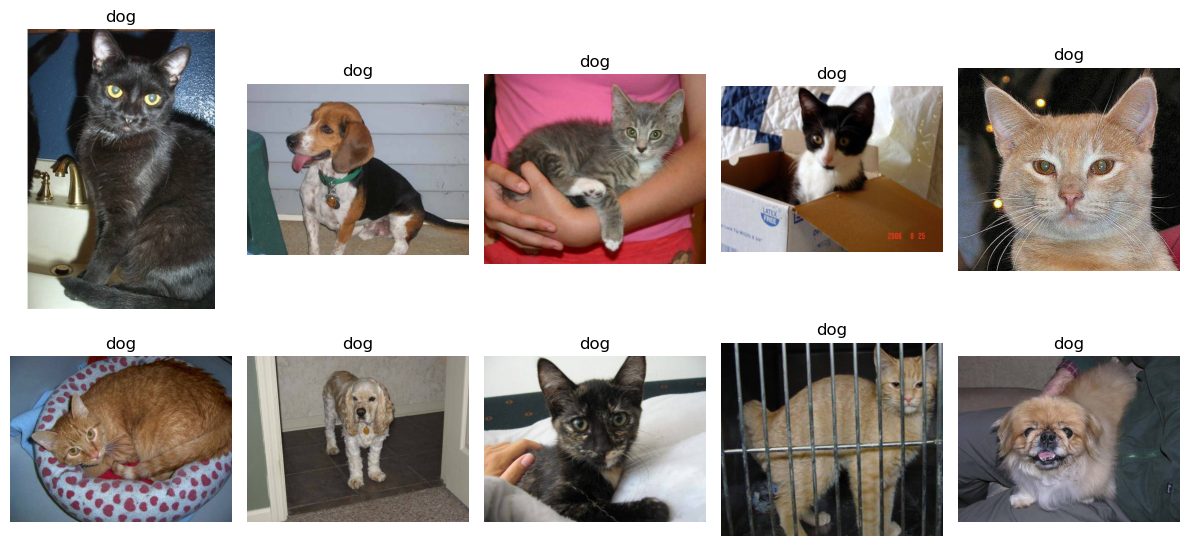

In [19]:
class_ = classes = {0:'cat', 1:'dog'}
def display_image_grid(images_filepaths, predicted_labels=(), cols=5):
    rows = len(images_filepaths) // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i, image_filepath in enumerate(images_filepaths):
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        a = random.choice(res['id'].values)    
        label = res.loc[res['id'] == a, 'label'].values[0]
        
        if label > 0.5:
            label = 1
        else:
            label = 0
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_title(class_[label])
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()
    
display_image_grid(test_images_filepaths) 

## 5-2. 객체 인식 (Object Detection)
> 이미지나 영상 내에 있는 객체를 식별하는 비전 기술
- 해당 객체의 위치가 어디인지, 박스(bounding box)로 나타내는 위치 검출(localization) 문제
- 1 단계 객체 인식(1-stage detector): 분류와 위치 검출 동시에 (빠르지만 정확도 낮음) / Yolo ...
- 2 단계 객체 인식(2-stage detector): 순차적 (느리지만 정확도 높음) / R-CNN ...

### 5-2-1. R-CNN (Region-based CNN)
- 기존 객체 인식 알고리즘들은, 슬라이딩 윈도우(sliding window) 방식을 이용
- 현재는, 선택적 탐색(selective search) 알고리즘을 적용한 후보 영역(region proposal) 사용

#### 선택적 탐색
1. 초기 영역 생성(sub-segmentation)
2. 작은 영역의 통합: Greedy
3. 후보 영역 생성

### 5-2-2. 공간 피라미드 풀링 (Saptial Pyramid Pooling)
> 고정된 이미지 크기를 사용하는 문제 해결
- Conv -> MaxPool -> 연결하기 -> FC -> CLF.
- 입력 이미지의 크기에 관계 없이 합성곱층을 통과 시키고, 특성맵을 동일한 사이즈로 변경하는 풀링층 적용

### 5-2-3. Fast R-CNN
> R-CNN의 속도 문제 개선, RoI 풀링 도입
- 선택적 탐색에서 찾은 바운딩 박스 정보가 CNN을 통과하면서 유지
- 최종 CNN 특성맵은 풀링을 적용해 FC을 통과하도록 크기 조정

#### RoI 풀링
![RoI](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2Fb6vdLi%2FbtrscNzKsuW%2Fgm0k8RObuX1ty5AUVJFLL0%2Fimg.png)
- 특성맵의 영역마다 스트라이드를 다르게 최대 풀링을 적용해 결과값을 동일하게 맞춤

### 5-2-4. Faster R-CNN
> 후보 영역 생성을 CNN 내부 네트워크에서 수행
- 선택적 탐색 -> CPU
- RPN(Region Proposal Network) -> GPU
  - 특성맵에 Conv 적용해, 특정 객체의 존재 여부 판단 + 후보 영역 바운딩
  - 객체들의 크기와 비율이 다양 -> 고정된 바운딩 박스 사용 불가
    - 여러 크기와 비율의 레퍼런스 박스(reference box) k개를 미리 정의하고, 각 슬라이딩 윈도우 위치마다 k개의 박스를 출력 -> 앵커(anchor)

## 5-3. 이미지 분할 (Image Segmentation)
> 이미지를 픽셀 단위로 분할

### 5-3-1. 완전 합성곱 네트워크 (Fully Convolution Network, FCN)
- 기존 FC층을 1x1 Conv로 대체 -> 위치 정보 유지 가능

### 5-3-2. 합성곱 & 역합성곱 네트워크 (Convolution & Deconvolution Network)
- 합성곱층과 풀링층을 거치면서 해상도가 낮아짐
- 낮아진 해상도를 복원하기 위해 업 샘플링 방식을 사용 -> 세부 정보 소실

#### 역합성곱
![역합성곱](https://thebook.io/img/080263/247_2.jpg)
- 특성맵 크기를 증가
1. 각 픽셀 주위에 제로 패딩(zero-padding) 추가
2. 합성곱 연산 수행

### 5-3-3. U-Net
![unet](https://miro.medium.com/v2/resize:fit:1400/1*qNdglJ1ORP3Gq77MmBLhHQ.png)
- 바이오 메디컬 이미지 분할 목적
- FCN 기반, 수축 경로(contracting path, 컨텍스트 포착)와 확장 경로(expansive path, 업 샘플링+컨텍스트 이용 지역화)로 구성
1. 속도가 빠름: 검증된 패치에 대해서는 검증 진행 X
2. 트레이드오프(trade-off)에 빠지지 않음
   1. 패치가 커짐 -> 넓은 범위의 이미지를 인식하는데 좋음
   2. 컨텍스트(context) 인식에 탁월
   3. 지역화에는 약해짐
   4. 컨텍스트 인식과 지역화 트레이드 오프 개선

### 5-3-4. PSPNet (Pyramid Scene Parsing Network)
- 시멘틱 분할 알고리즘
- FC 한계 극복을 위해, 피라미드 풀링 모듈 추가

### 5-3-5. DeepLabv3/DeepLabv3+
- FC 한계 극복을 위해, Atrous 합성곱(특성맵 해상도 제어) 이용
- 인코더/디코더 구조

#### Atrous
- 필터내부에 빈공간을 갖음